In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import euclidean

In [2]:
from fastdtw import fastdtw
import time

5.82842712475
[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]


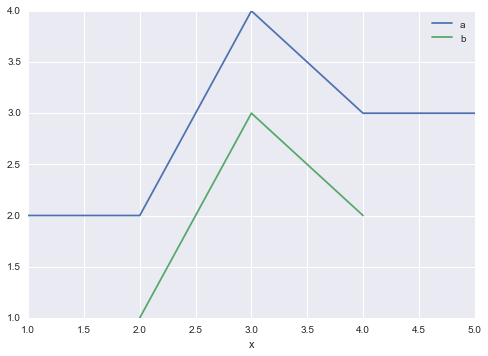

In [86]:
# https://pypi.python.org/pypi/fastdtw/0.3.0
# サンプル
ts_a = np.array([[1,2], [2,2], [3,4], [4,3], [5,3]])
ts_b = np.array([[2,1], [3,3], [4,2]])
# ts_b = np.array([[1,5], [2,4], [3,3], [4,2], [5,1]])
distance, path = fastdtw(ts_a, ts_b, dist=euclidean) #what is path
print(distance)
print(path)
plt.clf()

df_a=pd.DataFrame(ts_a,columns=["x","y"])
df_a.index=df_a.x
df_a.y.plot(label="a")

df_b=pd.DataFrame(ts_b,columns=["x","y"])
df_b.index=df_b.x
df_b.y.plot(label="b")

plt.legend(loc="best")

In [3]:
df_code=pd.read_csv("data/company_code.csv", sep='\t')
# http://www.jpx.co.jp/markets/indices/topix/ 浮動株比率の変更情報より
df_code=df_code[["SC","名称","市場","業種"]]
df_code.head()

,SC,名称,市場,業種
0,1,日経225（日経平均株価）,東証,株価指数
1,2,TOPIX（東証株価指数）,東証,株価指数
2,1301,極洋,東証一部,水産・農林
3,1332,日本水産,東証一部,水産・農林
4,1333,マルハニチロ,東証一部,水産・農林


In [ ]:
import sys
from_comp_code=2809
is_skip=0
fault_times=0
for i, row in df_code.query('市場 == ["東証一部"]').iterrows():
    if is_skip==0 and row["SC"] == from_comp_code:
        is_skip=1
    if is_skip==1:
        df_company_tmp=pd.DataFrame()
        
        for year in ["2014","2015","2016"]:
            success = True
            url="http://k-db.com/stocks/"+str(int(row["SC"]))+"-T/1d/"+year+"?download=csv"
            for _ in range(0,3):
                try:
                    df_tmp=pd.read_csv(url)
                    success = True
                    print("success reading "+url)
                    break
                except:
                    fault_times+=1
                    print("Failed to retrieve "+url)
                    time.sleep(60*fault_times)
                    success = False
            if success:
                print("success write csv "+url)
                df_tmp.to_csv("download/"+str(row["SC"])+row["名称"]+year+".csv")
                df_company_tmp=pd.concat([df_tmp,df_company_tmp])
#                 print(url)
                time.sleep(30)
            else:
                print("エラー多発")
                sys.exit()
        # まとめて保存
        df_company_tmp.reset_index().to_csv("download/"+str(row["SC"])+row["名称"]+".csv")

success reading http://k-db.com/stocks/2809-T/1d/2014?download=csv
success write csv http://k-db.com/stocks/2809-T/1d/2014?download=csv


In [16]:
# 250日分のデータ
df_nintendo=pd.read_csv("data/nintendo.csv")
df_softbank=pd.read_csv("data/softbank.csv")
df_yahoo=pd.read_csv("data/yahoo.csv")
df_kddi=pd.read_csv("data/kddi.csv")
df_nikkei=pd.read_csv("data/nikkei_heikin.csv")

In [17]:
df_nintendo.head()

,日付,始値,高値,安値,終値,出来高,売買代金
0,2016-07-29,21000.0,21780.0,20440.0,21505.0,10889500,229017468500
1,2016-07-28,22075.0,22600.0,20725.0,21080.0,14209600,304377757000
2,2016-07-27,22800.0,23240.0,21905.0,22305.0,9722400,218896692000
3,2016-07-26,22030.0,23890.0,21700.0,23590.0,16633600,380427751500
4,2016-07-25,23720.0,24555.0,23220.0,23220.0,11321100,267542530500


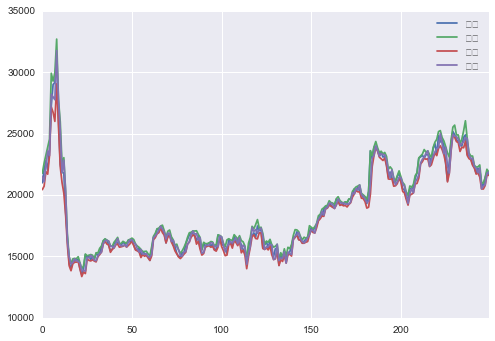

In [18]:
df_nintendo[["始値","高値","安値","終値"]].plot()

In [19]:
df_list=[df_nintendo,df_softbank,df_yahoo,df_kddi,df_nikkei]
name_list=["nintendo","softbank","yahoo","kddi","nikkei"]
df_noemalized_list=[]
for i in range(0,len(df_list)):
    df_list[i].index=pd.to_datetime(df_list[i]["日付"],format='%Y-%m-%d')
    df_noemalized_list.append((df_list[i]["始値"] - df_list[i]["始値"].mean()) / df_list[i]["始値"].std())
    

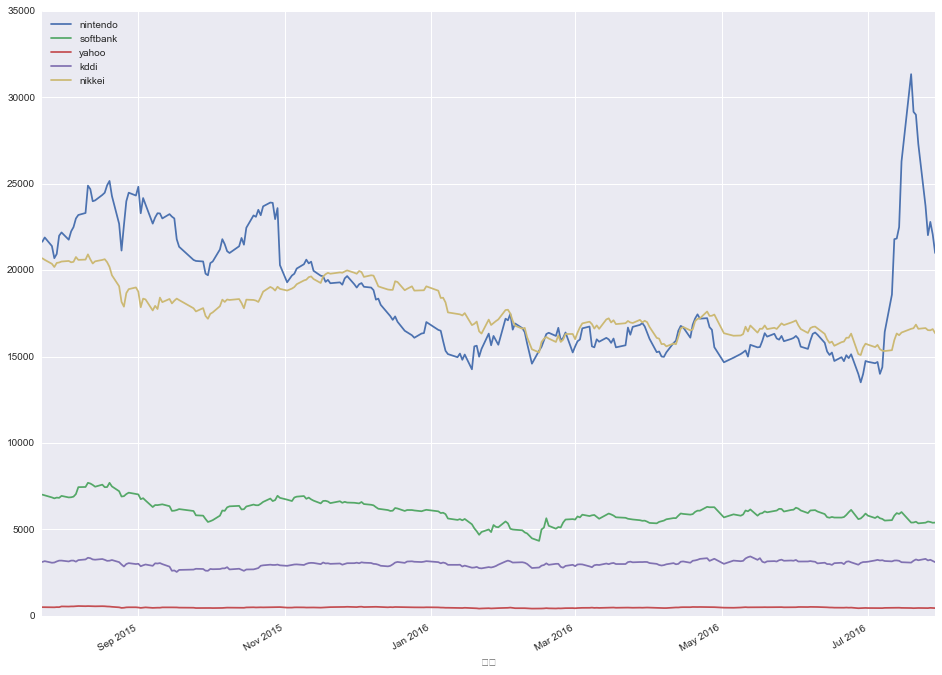

In [20]:
# 始値の推移
for (df_tmp,name_tmp) in zip(df_list,name_list):
    df_tmp["始値"].plot(label=name_tmp,figsize=(16, 12))
plt.legend(loc='best')

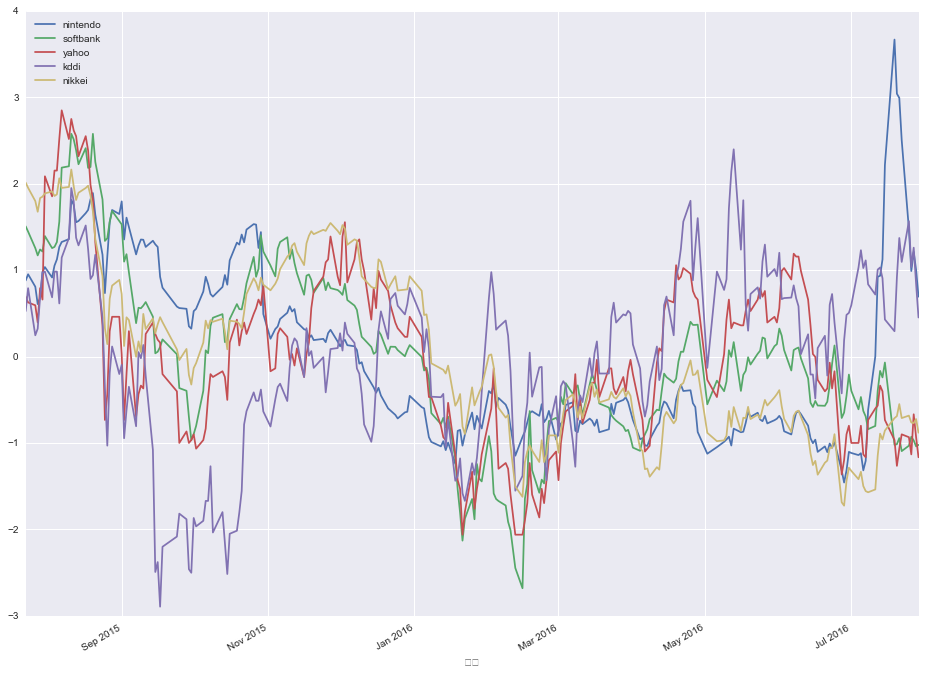

In [21]:
# 標準化後の始値推移
for (df_tmp,name_tmp) in zip(df_noemalized_list,name_list):
    df_tmp.plot(label=name_tmp,figsize=(16, 12))
plt.legend(loc='best')

In [22]:
count=np.arange(1,251)
def dtw_from_df(i,j):
#     print(name_list[i],name_list[j])
    a=np.c_[count,df_noemalized_list[i].as_matrix().astype(int)]
    b=np.c_[count,df_noemalized_list[j].as_matrix().astype(int)]
    distance, path = fastdtw(a, b, dist=euclidean)
    return distance, path

In [67]:
distance_list

[[0, 116.0, 120.0, 137.0, 106.0],
 [116.0, 0, 72.0, 137.0, 104.0],
 [120.0, 72.0, 0, 127.0, 86.0],
 [137.0, 137.0, 127.0, 0, 151.0],
 [106.0, 104.0, 86.0, 151.0, 0]]

In [68]:
distance_list=[[0 for _ in range(len(df_list))] for _ in range(len(df_list))]
for i in range(len(df_list)):
    for j in range(i+1,len(df_list)):
        distance, path = dtw_from_df(i,j)
        print(name_list[i]," & ",name_list[j],":",distance)
#         print(i,j,distance)
        distance_list[i][j], distance_list[j][i]=distance,distance

nintendo  &  softbank : 116.0
nintendo  &  yahoo : 120.0
nintendo  &  kddi : 137.0
nintendo  &  nikkei : 106.0
softbank  &  yahoo : 72.0
softbank  &  kddi : 137.0
softbank  &  nikkei : 104.0
yahoo  &  kddi : 127.0
yahoo  &  nikkei : 86.0
kddi  &  nikkei : 151.0


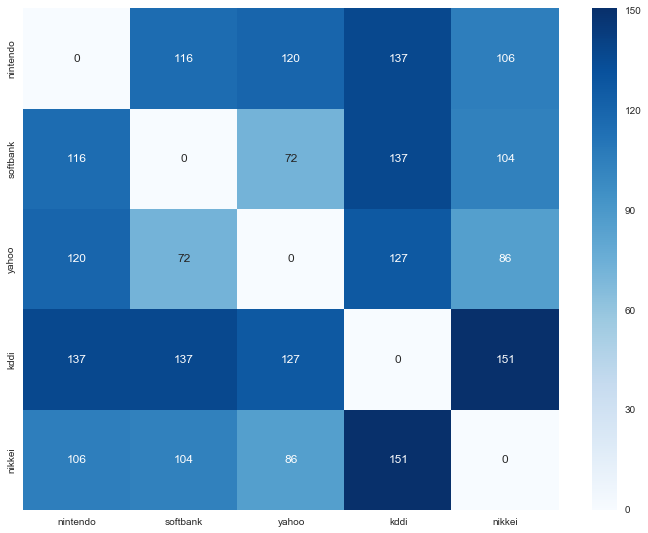

In [74]:
plt.figure(figsize=(12, 9))
sns.heatmap(pd.DataFrame(distance_list,columns=name_list,index=name_list), annot=True, fmt='g', cmap='Blues')

In [79]:
def plot_2_ts(i,j):
    distance, path = dtw_from_df(i,j)
    df_noemalized_list[i].plot(label=name_list[i])
    df_noemalized_list[j].plot(label=name_list[j])
    plt.legend(loc='best')
    print(distance)

151.0


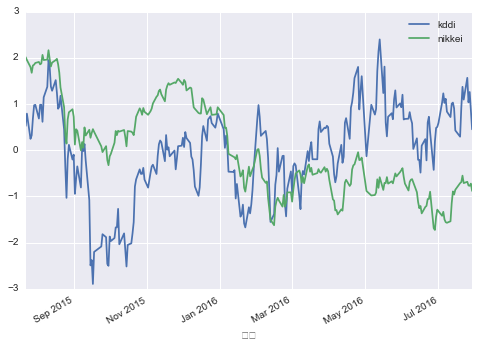

In [80]:
# 距離大きい
plot_2_ts(3,4)

72.0


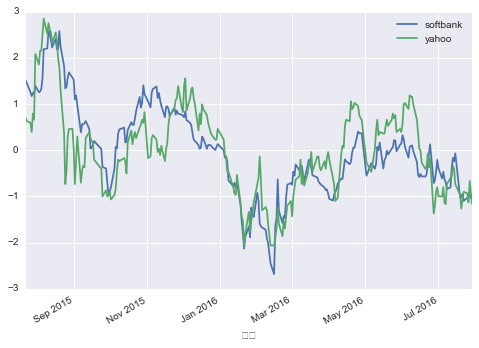

In [81]:
# 距離小さい
plot_2_ts(1,2)